In [103]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns
import numpy as np
import pyarrow.parquet as pq
#plt.style.use(['science', 'notebook'])

In [118]:
ss_id = 26855
total_df = pd.DataFrame()
j=0
parquet_file = pq.ParquetFile('UK/30min.parquet')
for i in parquet_file.iter_batches(batch_size=1e7):
    if j %100 == 0:
        print('One step further.')
    df = i.to_pandas()
    df = df[df['ss_id'] == ss_id]
    total_df = pd.concat([total_df, df])
    j += 1

print(total_df)
total_df.to_pickle('UK/ProdUK.pkl')

One step further.
One step further.
One step further.
         generation_wh            datetime  ss_id
1618873            0.0 2018-04-18 00:00:00  26855
1638364            0.0 2018-04-18 00:30:00  26855
1660361            0.0 2018-04-18 01:00:00  26855
1681258            0.0 2018-04-18 01:30:00  26855
1716611            0.0 2018-04-18 02:00:00  26855
...                ...                 ...    ...
4245045            0.0 2020-09-30 21:30:00  26855
4283428            0.0 2020-09-30 22:00:00  26855
4299272            0.0 2020-09-30 22:30:00  26855
4311827            0.0 2020-09-30 23:00:00  26855
4338802            0.0 2020-09-30 23:30:00  26855

[43056 rows x 3 columns]


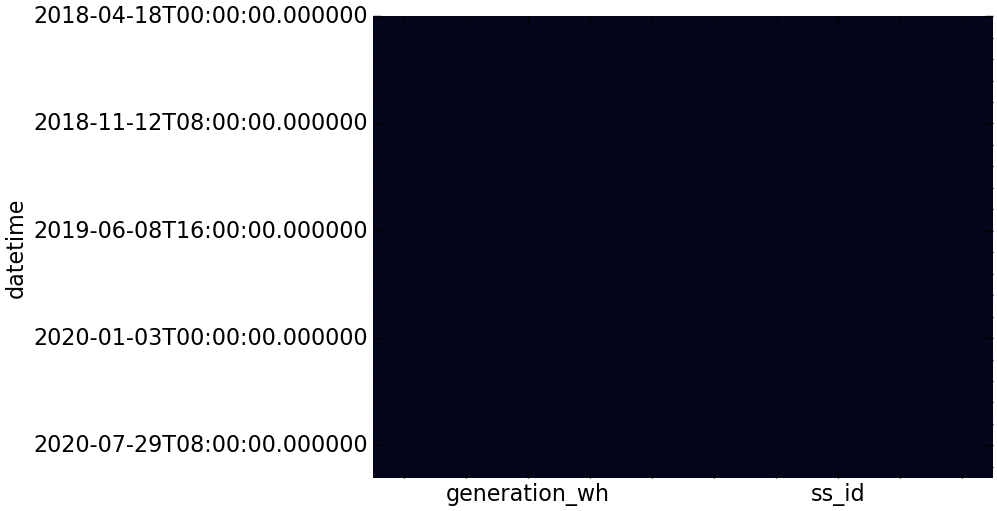

2018-04-18 00:00:00 2020-09-30 23:30:00
No missing chronological data.


In [120]:
total_df = pd.read_pickle("UK/ProdUK.pkl")
total_df['datetime'] = pd.to_datetime(total_df['datetime'])
total_df = total_df.set_index('datetime')



# total_df = total_df.reindex(expected_timestamps, axis=0)
sns.heatmap(total_df.isnull(), cbar=False, yticklabels=10000)
plt.show()

start = total_df.index.min()
end = total_df.index.max()
print(start, end)
expected_timestamps = pd.date_range(start=start, end=end, freq='30min')  # Assuming data is recorded every 15 minutes

missing_timestamps = expected_timestamps[~expected_timestamps.isin(total_df.index)]

if not missing_timestamps.empty:
    print(f" Missing Timestamps: {missing_timestamps}")
else:
    print(f"No missing chronological data.")



In [121]:
solar_generation = total_df.loc["2019-05-01":"2020-05-01"]
solar_generation = solar_generation[["generation_wh"]]
print(solar_generation.isna().sum())
print((solar_generation < 0).sum())
print(solar_generation)

generation_wh    32
dtype: int64
generation_wh    0
dtype: int64
                     generation_wh
datetime                          
2019-05-01 00:00:00            NaN
2019-05-01 00:30:00            0.0
2019-05-01 01:00:00            0.0
2019-05-01 01:30:00            0.0
2019-05-01 02:00:00            0.0
...                            ...
2020-05-01 21:30:00            0.0
2020-05-01 22:00:00            0.0
2020-05-01 22:30:00            0.0
2020-05-01 23:00:00            0.0
2020-05-01 23:30:00            0.0

[17616 rows x 1 columns]


,generation_wh
datetime,
2019-05-01 00:00:00,NaN
2019-05-01 22:00:00,NaN
2019-05-01 22:30:00,NaN
2019-05-01 23:00:00,NaN
2019-05-01 23:30:00,NaN
2019-05-17 00:00:00,NaN
2019-05-17 22:00:00,NaN
2019-05-17 22:30:00,NaN
2019-05-17 23:00:00,NaN


<Axes: ylabel='datetime'>

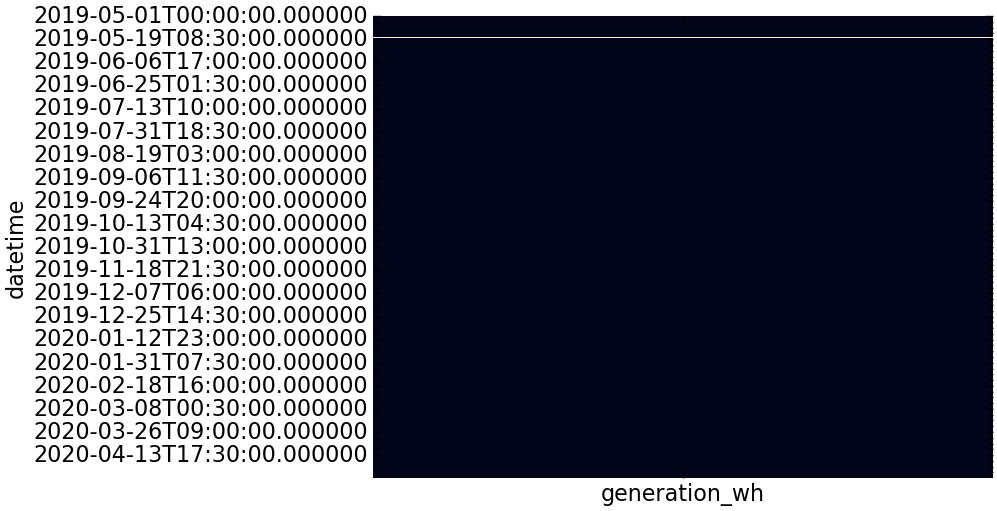

In [122]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(solar_generation.loc[solar_generation.isna().any(axis=1)])
sns.heatmap(solar_generation.isnull(), cbar=False)

In [123]:
# We know earliest sunrise in uk is 05:00 and latest sunset is 21:00 so we can put all NaN between these times to zero
sunrise = 5
sunset=21
solar_generation[solar_generation.index.hour < sunrise] = 0
solar_generation[solar_generation.index.hour >= sunset] = 0
print(solar_generation.isna().sum())
#This eliminates 50 NaN

generation_wh    10
dtype: int64


In [124]:
#Next up is data that is one missing between 2 known values --> interpolate, can use simple function bcs stays NaN
solar_generation[solar_generation.isnull()] = (solar_generation.shift(-1)+solar_generation.shift(1))/2
print(solar_generation.isna().sum())


generation_wh    0
dtype: int64


In [125]:
solar_generation.to_pickle("Data/prod_UK.pkl")